# Descrição problema

- Os estados são as células de um hipercubo de dimensão $n$, com lados de tamanho $H$

- Os estados começam nas coordenadas $x = (0, 0, ...)$

- Uma ação $a_i$ aumenta a $i$-ésima coordenada em 1

- O episódio continua até que uma coordenada atinja $H$ ou uma ação de parada seja realizada

- Há uma versão disto em que as coordenadas também podem ser reduzidas
    - Isto é feito para Monte Carlo com Redes de Markov (MCMC)

- A função recompensa é a seguinte:

$$ R(x) = R_0 + R_1 \prod_i I\left(0.25 < \left \lvert \frac{x_i}{H}-0.5 \right \rvert \right) + R_2 \prod_i I\left(0.3< \left \lvert \frac{x_i}{H}-0.5 \right \rvert < 0.4 \right)$$

$$ R_1=\frac{1}{2}, R_2 = 2 $$

- Para esta combinação de $R_1, R_2$ há sempre exatamente $2^n$ máximos locais (modas).

- Ou seja, $R_0$ $+ R_1$ caso $x_1$ esteja perto (0.5) de $0$ ou $H$ $+ R_2$ caso $x_i$ esteja mais perto mas não tanto de $H$ (0.3-0.4)

- A função de erro utilizada é a $L1$: $ | p(x) - \pi (x) | $
- $ p(x) = \frac{R(x)}{Z}$ é conhecido

- O experimento é executado para as seguintes parametrizações:
    - $R_0 \in \{ 10^{-3}, 10^{-2}, 10^{-1} \}$
    - $ n = 4 $
    - $ H = 8 $

# Descrições do programa

- A estrutura de um estado será um tensor unidmensional de comprimento H+1, onde seu primeiro elemento será a ação de parada e os outros elementos serão as coordenadas $\{1, ..., H\}$

In [412]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import tqdm
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
import numpy as np

torch.autograd.set_detect_anomaly(True)

In [456]:
n = 2
H = 8
R0 = 10**-1
R1 = 0.5
R2 = 2

# structure of the state:
# torch.zeros(H)

In [274]:
def stopped(state):
    return state[0]>=1 or torch.any(state[1:]>=H)


def get_reward(state):
    cond_R1 = torch.all(0.25 < torch.abs(state[1:] / H - 0.5))
    cond_R2_lower = torch.all(0.23 < torch.abs(state[1:] / H - 0.5))
    cond_R2_upper = torch.all(torch.abs(state[1:] / H - 0.5) < 0.4)
    cond_R2 = cond_R2_lower and cond_R2_upper

    if stopped(state):
        return R0 + R1 * cond_R1 + R2 * cond_R2
    return 0


def transition(state, action, forward=True):
    state = state.clone()
    if forward:
        state[action] += 1
    else: # Transitions backwards
        state[action] -= 1
    return state


def transition_random(state):
    action = torch.randint(0, n, (1,))
    return transition(state, action)


def get_parents(state):
    parent_states = []
    parent_actions = []

    for i in range(len(state)):
        if state[i]>0:
            
            parent_states.append(
                transition(
                    state.clone(),
                    i,
                    forward=False,
                )
            )
            parent_actions.append(torch.tensor(i))
    
    return parent_states, parent_actions

In [473]:
class GraphAgent(nn.Module):

    def __init__(
        self,
        n: int,
        hid_lay: int,
    ):
        self.n = n

        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(self.n+1, hid_lay), nn.LeakyReLU(),
            nn.Linear(hid_lay, hid_lay), nn.LeakyReLU(),
            nn.Linear(hid_lay, 2*(self.n+1))
        )
        self.logZ = nn.Parameter(torch.ones(1))
    
    def forward(self, x):
        # We can't have coordinates higher than H
        # And we don't 
        F = self.mlp(x)
        # F[0] = 0

        P_F = F[..., :self.n+1] + x * -1
        P_B = F[..., self.n+1:] + x * -1

         # Stopping action found
        # if x.dim() == 1:
        #     P_F[0] *= 1 - int(x[0]==1)
        #     # P_B *= 1 - int(x[0]1)
        # elif x.dim() == 2:
        #     P_F *= 1 - (x[:, 0] > 1).to(torch.int).unsqueeze(1)
        #     P_B *= 1 - (x[:, self.n+1] == 0).to(torch.int).unsqueeze(1)
        
        # # We can't have coordinates higher than H
        # if x.dim() == 1:
        #     P_F *= 1 - torch.any(x[1:n+1]>self.n).to(torch.int)
        # elif x.dim() == 2:
        #     F *= 1 - torch.any(
        #         x[:, 1:]>self.n,
        #         dim=1,
        #     ).to(torch.int).unsqueeze(1) # Condition of not going over H
        
        return P_F, P_B

In [474]:
update_freq = 3

model = GraphAgent(
    n=n,
    hid_lay=100,
)
opt = torch.optim.Adam(model.parameters(), 3e-4)
episodes = 1000

minibatch_loss = 0
losses_gfn = []
states = []
modes_found_gfn = torch.zeros((2,)*n)

for episode in tqdm.tqdm(range(episodes)):
    state = torch.zeros(n+1)
    # Dentro do episódio, iterando 
    P_F_s, P_B_s = model(state)
    total_P_F = 0
    total_P_B = 0
    while not stopped(state):
        cat = Categorical(logits=P_F_s)
        action = cat.sample()
        new_state = transition(state, action)
        
        reward = get_reward(new_state)

        P_F_s, P_B_s = model(new_state)
        total_P_F = cat.log_prob(action)
        total_P_B += Categorical(logits=P_B_s).log_prob(action)

        state = new_state

    loss = abs(model.logZ + total_P_F - torch.log(reward) - total_P_B)
    minibatch_loss += loss

    if episode % update_freq == 0:
        # Register modes found
        coords_value = state[1:]/H-0.5
        if torch.all(0.3<abs(coords_value)) and torch.all(abs(coords_value)<0.4):
            # two applications of torch.sign transform [-0.45, 0.32] into [0, 1]
            coords = tuple(
                torch.sign( 
                    torch.sign(coords_value)+1
                ).to(torch.int).tolist()
            )
            modes_found_gfn[coords] = 1

        losses_gfn.append(minibatch_loss.item())

        minibatch_loss.backward()
        opt.step()
        opt.zero_grad()
        minibatch_loss = 0
        states.append(state)

 55%|█████▌    | 550/1000 [04:07<05:43,  1.31it/s]

In [472]:
state[1:]/H-0.5

tensor([0.3750, 0.5000])

In [470]:
modes_found_gfn

tensor([[1., 0.],
        [0., 0.]])

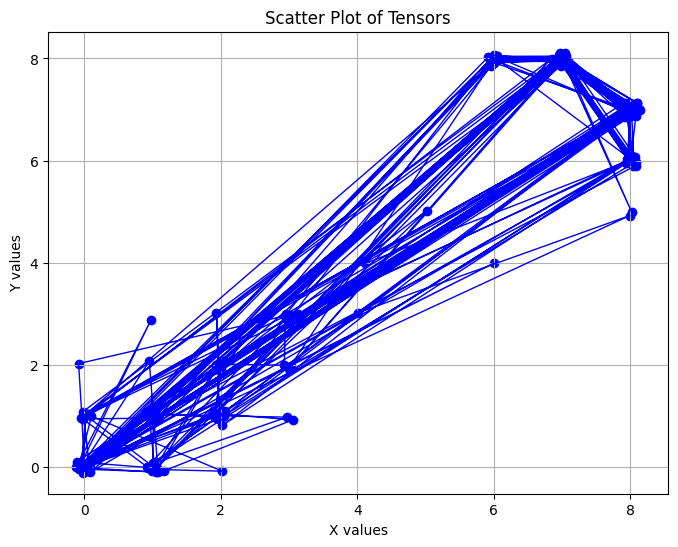

In [468]:
# Step 1: Extract x and y values from the states
noise_level = 0.05
x_values = [tensor[1].item() + noise_level * torch.randn(1).item() for tensor in states]
y_values = [tensor[2].item() + noise_level * torch.randn(1).item() for tensor in states]

# Step 2: Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(x_values, y_values, c='blue', marker='o')

# Add a line connecting the points
plt.plot(x_values, y_values, c='blue', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Scatter Plot of Tensors')
plt.grid(True)

# Show the plot
plt.show()

Text(0, 0.5, 'loss')

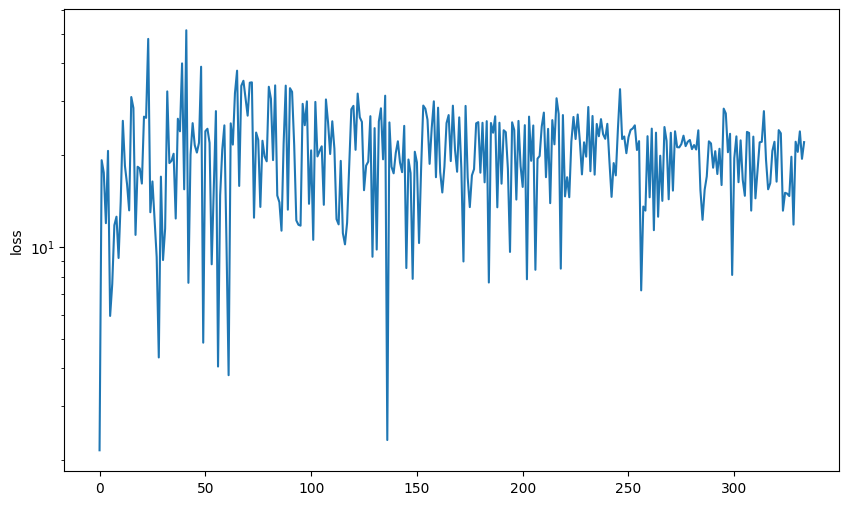

In [469]:
f, ax = plt.subplots(1, 1, figsize=(10,6))
plt.sca(ax)
plt.plot(losses_gfn)
plt.yscale('log')
plt.ylabel('loss')

In [252]:
def propose_new_state(current_state):
    # Propose a new state from a Gaussian distribution around the current state
    new_state = transition_random(current_state)
    return new_state


def metropolis_hastings_acceptance(current_state, proposed_state, reward_function):
    current_reward = reward_function(current_state)
    proposed_reward = reward_function(proposed_state)
    
    if proposed_reward >= current_reward:
        return True
    else:
        acceptance_prob = np.exp(proposed_reward - current_reward)
        return np.random.uniform(0, 1) < acceptance_prob


def mcmc_local_max_search(initial_state, reward_function, proposal_std, num_steps):
    current_state = initial_state.clone()
    max_reward = reward_function(current_state)
    max_state = current_state.clone()
    
    for step in range(num_steps):
        proposed_state = propose_new_state(current_state, proposal_std)
        if metropolis_hastings_acceptance(current_state, proposed_state, reward_function):
            current_state = proposed_state
            current_reward = reward_function(current_state)
            if current_reward > max_reward:
                max_reward = current_reward
                max_state = current_state
    
    return max_state, max_reward

In [ ]:
current_state = torch.zeros(H+1)
max_reward = get_reward(current_state)
max_state = current_state.clone()

for i in range(1000):
    proposed_state = propose_new_state(current_state, 0.1)
    if metropolis_hastings_acceptance(current_state, proposed_state, get_reward):
            current_state = proposed_state
            current_reward = get_reward(current_state)
            if current_reward > max_reward:
                max_reward = current_reward
                max_state = current_state 

In [257]:
mcmc_local_max_search(torch.zeros(H+1), get_reward, 0.1, episodes)

(tensor([0., 0., 0., 0., 4., 1., 1., 2., 0.]), tensor(0.1000))

In [238]:
import numpy as np

def metropolis_hastings(initial_state, num_samples, proposal_variance):
    current_state = initial_state.clone()
    samples = []
    
    for _ in range(num_samples):
        # Propose a new state
        proposal = current_state + torch.randn(H+1)*proposal_variance
        
        # Compute acceptance probability
        current_prob = model(torch.tensor(current_state)).exp().sum().item()
        proposal_prob = model(torch.tensor(proposal)).exp().sum().item()
        
        acceptance_prob = min(1, proposal_prob / current_prob)
        
        # Accept or reject the proposal
        if np.random.rand() < acceptance_prob:
            current_state = proposal
        
        samples.append(current_state)
    
    return samples

# Example usage
initial_state = torch.zeros(H+1)
num_samples = 10000
proposal_variance = 0.1

mcmc_samples = metropolis_hastings(initial_state, num_samples, proposal_variance)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3852\1701595814.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_prob = model(torch.tensor(current_state)).exp().sum().item()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3852\1701595814.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proposal_prob = model(torch.tensor(proposal)).exp().sum().item()


In [242]:
mcmc_samples

[tensor([-0.0666,  0.1782,  0.0385, -0.1843, -0.2158, -0.0949,  0.0390,  0.0404,
          0.0057]),
 tensor([-0.0950,  0.1510, -0.0936, -0.1042, -0.0569, -0.1478,  0.2655,  0.0618,
         -0.0753]),
 tensor([-0.1226,  0.1406, -0.0252, -0.2039, -0.1699, -0.1231,  0.1841,  0.1390,
         -0.0682]),
 tensor([-0.0137,  0.1148, -0.1924, -0.3281, -0.2171, -0.1589,  0.2266,  0.0969,
         -0.0939]),
 tensor([-0.0137,  0.1148, -0.1924, -0.3281, -0.2171, -0.1589,  0.2266,  0.0969,
         -0.0939]),
 tensor([-0.1160,  0.0836, -0.0953, -0.2730, -0.3375, -0.1385,  0.2161,  0.0355,
         -0.1557]),
 tensor([-0.1160,  0.0836, -0.0953, -0.2730, -0.3375, -0.1385,  0.2161,  0.0355,
         -0.1557]),
 tensor([-0.2916,  0.1650, -0.2803, -0.2968, -0.2139, -0.1284,  0.2547,  0.2367,
         -0.1100]),
 tensor([-0.3283,  0.2226, -0.3176, -0.2636, -0.3388, -0.0964,  0.1359,  0.1221,
         -0.0548]),
 tensor([-0.3283,  0.2226, -0.3176, -0.2636, -0.3388, -0.0964,  0.1359,  0.1221,
         -